In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader
from skimage.measure import compare_ssim, compare_mse
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import AWLoss
from datasets import UndersampledUltrasoundDataset3D


import matplotlib.pyplot as plt
import progressbar
import plotly.express as px
import plotly.graph_objects as go

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=150
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)


# Losses
l2loss     = nn.MSELoss(reduction="sum")
awloss     = AWLoss(filter_dim=2, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)


Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


# MRI Dataset 

In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

{'name': 'UndersampledUltrasoundDataset3D', 'path': '/media/dekape/HDD Storage/Ultrasound-MRI_volumes/173940', 'transform': Compose(
    Lambda()
    Lambda()
), 'undersample_width': (1, 1, 3), 'mode': 'mri', 'fill': 0.0, 'len': 1} 

torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


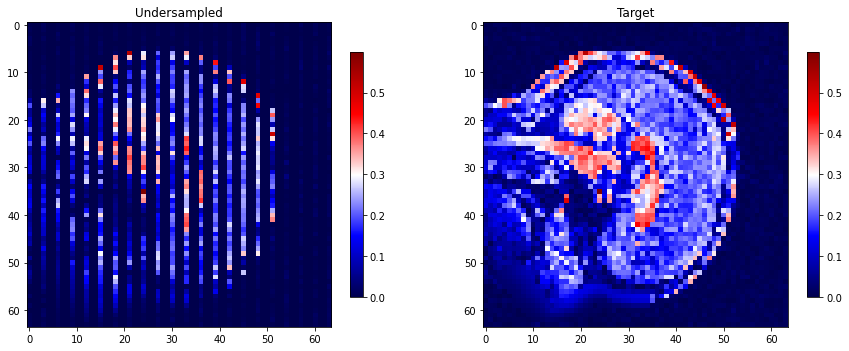

In [18]:
# Dataset
path = os.path.abspath("/media/dekape/HDD Storage/Ultrasound-MRI_volumes/173940")
train_transform = Compose([
                    Lambda(lambda x: resize(x, 64, 64, 64)),
                    # Resize(64),
                    Lambda(lambda x: x / x.abs().max()),
                    # Lambda(lambda x: scale2range(x)),
                    # Normalize(0., 1.),
                    ])
trainds = UndersampledUltrasoundDataset3D(path, 
                                        mode="mri",
                                        transform=train_transform,
                                        undersample_width=(1,1,3))
print(trainds, "\n")

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

# Sample for visualisation
x_sample, y_sample = trainds[0]
print(x_sample.shape, y_sample.shape)

idx = int(x_sample.shape[0]/2)
vmin, vmax, cmap =  None, None, "seismic"
fig, axs = plt.subplots(1,2, figsize=(15,15))

im = axs[0].imshow(x_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[0], shrink=0.3)
axs[0].set_title("Undersampled")

im = axs[1].imshow(y_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[1], shrink=0.3)
axs[1].set_title("Target")
plt.show()

In [19]:
trainds.info(nsamples=1)

{'max': tensor(0.9833),
 'min': tensor(0.),
 'mean': tensor(0.0298),
 'std': tensor(0.0828),
 'shape': torch.Size([64, 64, 64])}

## Model 

In [20]:
def make_model(channels=64):
    return UNet(
    spatial_dims=2,
    in_channels=channels,
    out_channels=channels,
    channels=(16, 32, 64, 128, 256),
    strides=tuple([2 for i in range(channels)]), 
    num_res_units=2,
    act="mish",
).to(device)

## Train and Validate Functions

In [21]:
def train(model, train_loader, optimizer, criterion, device="cpu"):
    """ Trains one epoch"""
    model.train()
    
    total_loss = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.sigmoid(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)

        # Backprop and optim step
        loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
    
    return total_loss

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates loss of a data loader of an autoencoder """
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        for i , (X, target) in enumerate(train_loader):
            X, target = X.to(device), target.to(device)
            
            # Forward Pass
            recon = torch.sigmoid(model(X))

            # Evaluate losses
            loss  = criterion(recon, target)
            
            total_loss += loss / len(train_loader)
    return total_loss

# Training

In [22]:
def train_model(model, optimizer, loss, train_loader, valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    train_losses, valid_losses, ssim = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            epoch_loss = train(model, train_loader, optimizer, loss, device=device)
            # validate
            # ssim score, aco_diff = compare_ssim(ela_real, aco_real, full=True, gaussian_weights=True)
            train_losses.append(epoch_loss.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "loss": epoch_loss.item(), "ssim (validation)":-1.}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 15))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(train_losses, label="train")
                axs[0].plot(valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(ssim)
                axs[1].set_xlabel("epoch")
                axs[1].set_title("SSIM")

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.sigmoid(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx])#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy())#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx])#, vmin=X.min(), vmax=X.max())
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        if "awloss" in str(loss).lower():
                            v, T = loss.filters[0], loss.T
                            
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        else:
                            pass


            plt.show()

In [23]:
# model = make_model(channels=x_sample.shape[0])
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_model(model, optimizer, l2loss, train_loader, valid_loader=None, nepochs=nepochs, log_frequency=25, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 44.39207458496094, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 346773


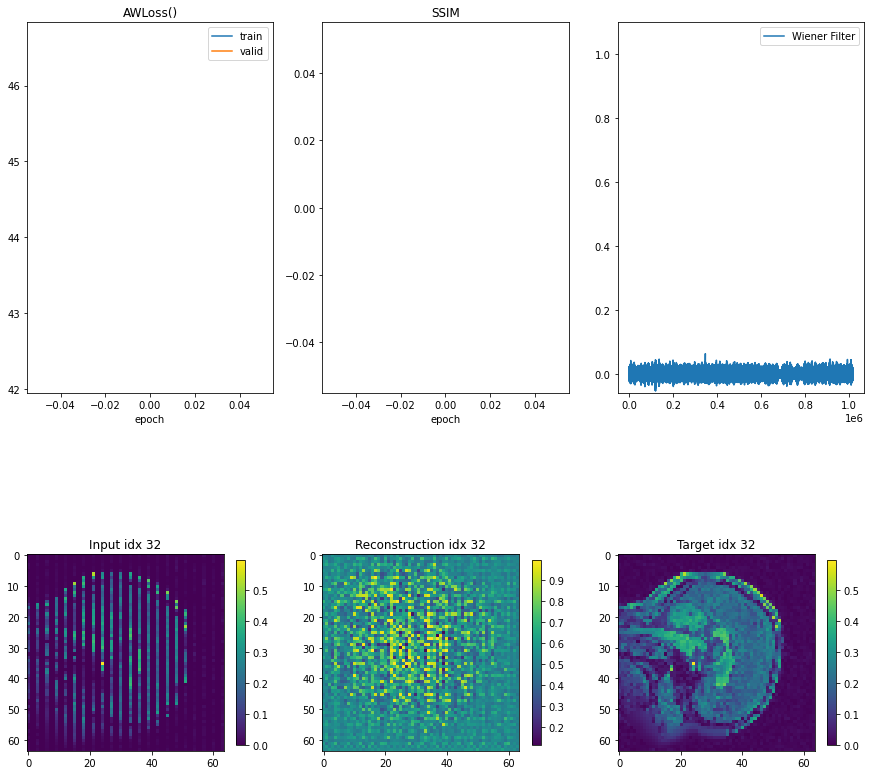

  0% (1 of 300) |                        | Elapsed Time: 0:00:01 ETA:   0:09:45
  0% (2 of 300) |                        | Elapsed Time: 0:00:02 ETA:   0:06:57
  1% (3 of 300) |                        | Elapsed Time: 0:00:03 ETA:   0:06:01
  1% (4 of 300) |                        | Elapsed Time: 0:00:04 ETA:   0:04:13
  1% (5 of 300) |                        | Elapsed Time: 0:00:05 ETA:   0:04:13
  2% (6 of 300) |                        | Elapsed Time: 0:00:06 ETA:   0:04:12
  2% (7 of 300) |                        | Elapsed Time: 0:00:07 ETA:   0:04:09
  2% (8 of 300) |                        | Elapsed Time: 0:00:07 ETA:   0:04:08
  3% (9 of 300) |                        | Elapsed Time: 0:00:08 ETA:   0:04:06
  3% (10 of 300) |                       | Elapsed Time: 0:00:09 ETA:   0:04:04
  3% (11 of 300) |                       | Elapsed Time: 0:00:10 ETA:   0:04:04
  4% (12 of 300) |                       | Elapsed Time: 0:00:11 ETA:   0:04:05
  4% (13 of 300) |                      


 {'epoch': 50, 'loss': 36.742042541503906, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 911288


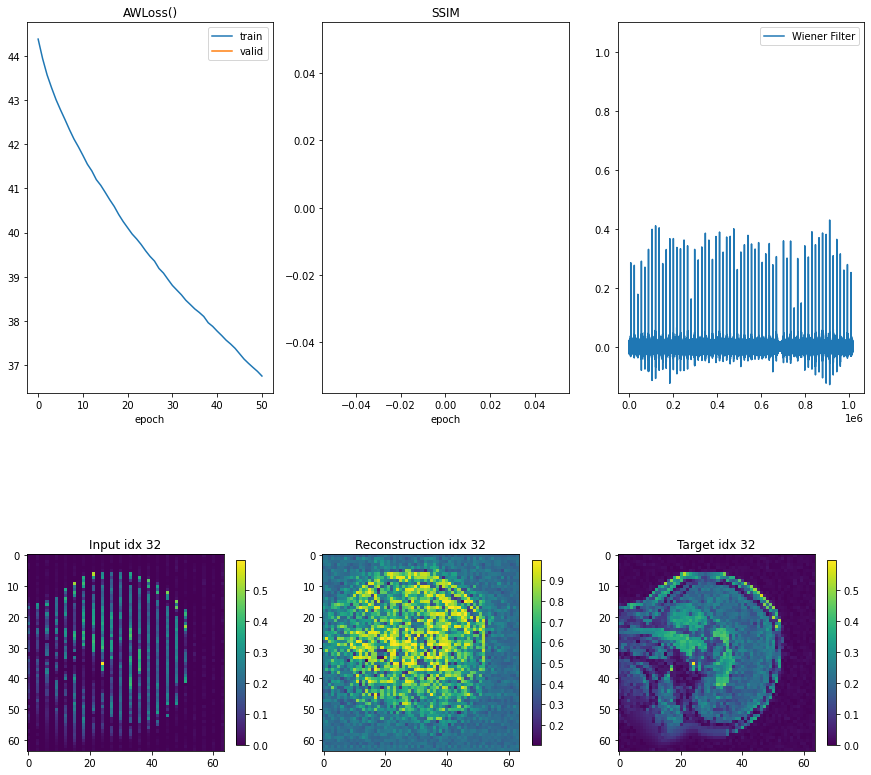

 17% (51 of 300) |###                    | Elapsed Time: 0:00:45 ETA:   0:05:43
 17% (52 of 300) |###                    | Elapsed Time: 0:00:46 ETA:   0:05:42
 17% (53 of 300) |####                   | Elapsed Time: 0:00:47 ETA:   0:05:00
 18% (54 of 300) |####                   | Elapsed Time: 0:00:48 ETA:   0:03:31
 18% (55 of 300) |####                   | Elapsed Time: 0:00:49 ETA:   0:03:33
 18% (56 of 300) |####                   | Elapsed Time: 0:00:49 ETA:   0:03:30
 19% (57 of 300) |####                   | Elapsed Time: 0:00:50 ETA:   0:03:31
 19% (58 of 300) |####                   | Elapsed Time: 0:00:51 ETA:   0:03:29
 19% (59 of 300) |####                   | Elapsed Time: 0:00:52 ETA:   0:03:28
 20% (60 of 300) |####                   | Elapsed Time: 0:00:53 ETA:   0:03:27
 20% (61 of 300) |####                   | Elapsed Time: 0:00:54 ETA:   0:03:24
 20% (62 of 300) |####                   | Elapsed Time: 0:00:55 ETA:   0:03:24
 21% (63 of 300) |####                  


 {'epoch': 100, 'loss': 32.97416687011719, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 411289


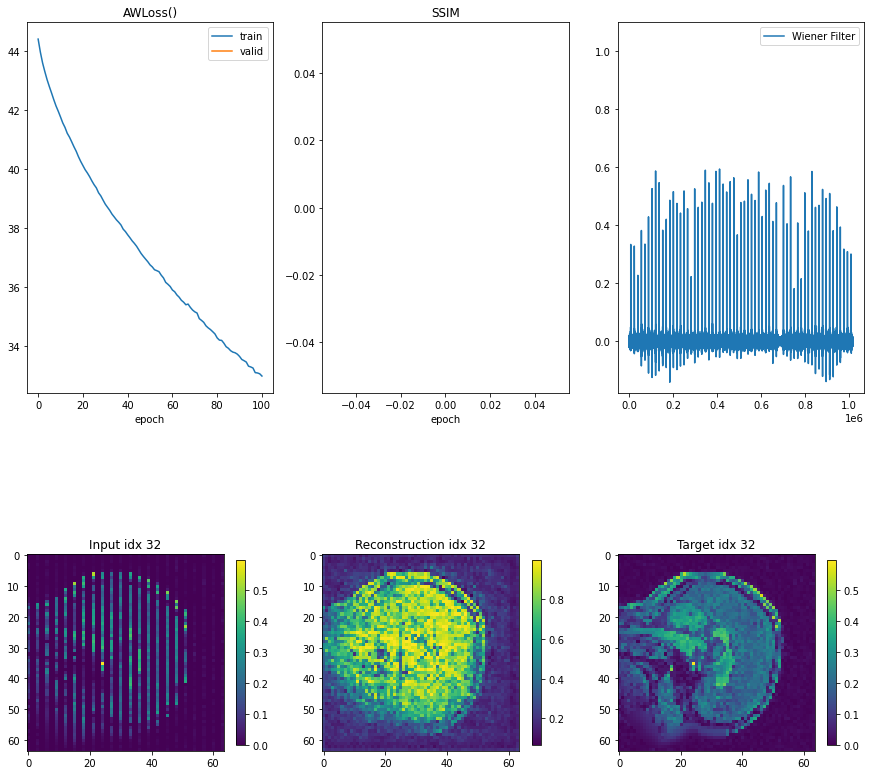

 33% (101 of 300) |#######               | Elapsed Time: 0:01:29 ETA:   0:04:31
 34% (102 of 300) |#######               | Elapsed Time: 0:01:30 ETA:   0:04:30
 34% (103 of 300) |#######               | Elapsed Time: 0:01:31 ETA:   0:03:55
 34% (104 of 300) |#######               | Elapsed Time: 0:01:32 ETA:   0:02:46
 35% (105 of 300) |#######               | Elapsed Time: 0:01:33 ETA:   0:02:46
 35% (106 of 300) |#######               | Elapsed Time: 0:01:33 ETA:   0:02:45
 35% (107 of 300) |#######               | Elapsed Time: 0:01:34 ETA:   0:02:44
 36% (108 of 300) |#######               | Elapsed Time: 0:01:35 ETA:   0:02:42
 36% (109 of 300) |#######               | Elapsed Time: 0:01:36 ETA:   0:02:41
 36% (110 of 300) |########              | Elapsed Time: 0:01:37 ETA:   0:02:40
 37% (111 of 300) |########              | Elapsed Time: 0:01:38 ETA:   0:02:39
 37% (112 of 300) |########              | Elapsed Time: 0:01:38 ETA:   0:02:39
 37% (113 of 300) |########             


 {'epoch': 150, 'loss': 30.50537872314453, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 120967


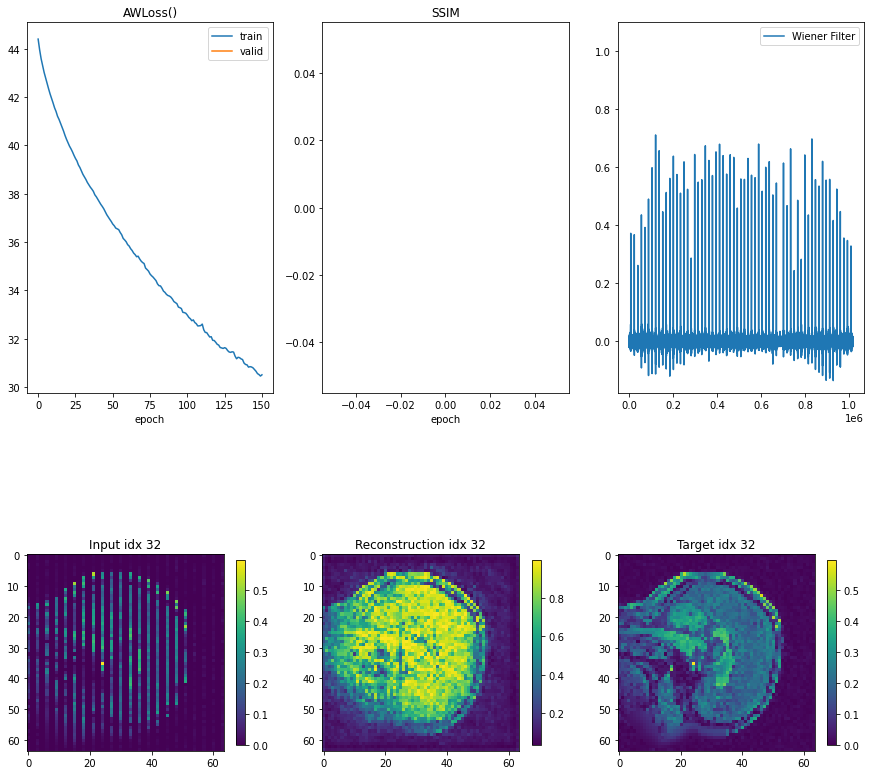

 50% (151 of 300) |###########           | Elapsed Time: 0:02:13 ETA:   0:05:03
 50% (152 of 300) |###########           | Elapsed Time: 0:02:14 ETA:   0:03:34
 51% (153 of 300) |###########           | Elapsed Time: 0:02:15 ETA:   0:03:04
 51% (154 of 300) |###########           | Elapsed Time: 0:02:16 ETA:   0:02:06
 51% (155 of 300) |###########           | Elapsed Time: 0:02:16 ETA:   0:02:04
 52% (156 of 300) |###########           | Elapsed Time: 0:02:17 ETA:   0:02:02
 52% (157 of 300) |###########           | Elapsed Time: 0:02:18 ETA:   0:02:00
 52% (158 of 300) |###########           | Elapsed Time: 0:02:19 ETA:   0:02:00
 53% (159 of 300) |###########           | Elapsed Time: 0:02:20 ETA:   0:01:59
 53% (160 of 300) |###########           | Elapsed Time: 0:02:21 ETA:   0:01:58
 53% (161 of 300) |###########           | Elapsed Time: 0:02:21 ETA:   0:01:58
 54% (162 of 300) |###########           | Elapsed Time: 0:02:22 ETA:   0:01:58
 54% (163 of 300) |###########          


 {'epoch': 200, 'loss': 28.817886352539062, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 120967


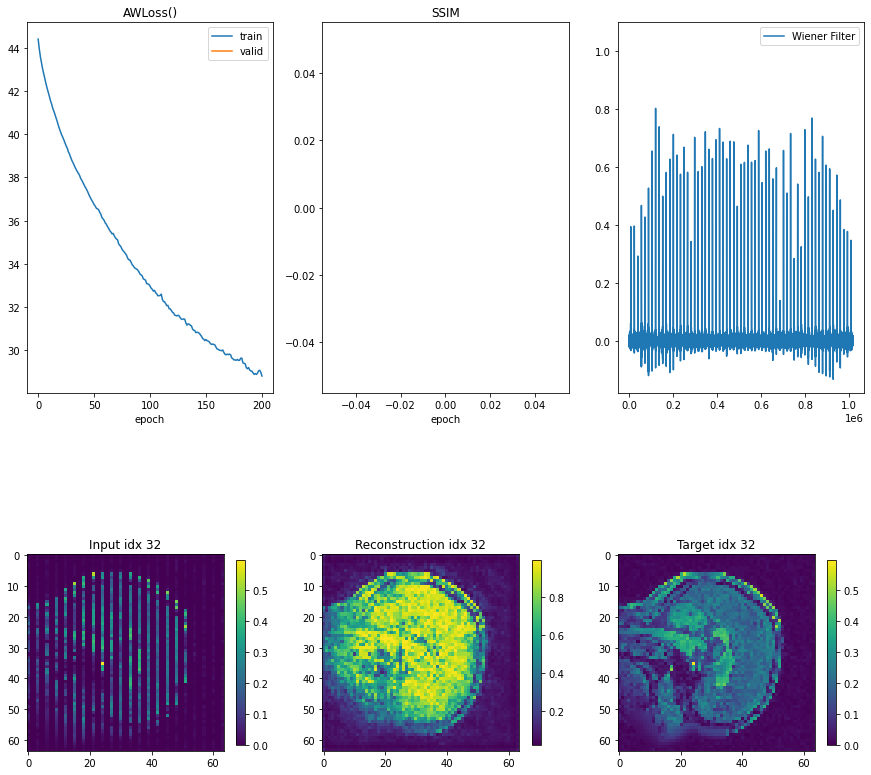

 67% (201 of 300) |##############        | Elapsed Time: 0:02:57 ETA:   0:02:17
 67% (202 of 300) |##############        | Elapsed Time: 0:02:58 ETA:   0:02:15
 67% (203 of 300) |##############        | Elapsed Time: 0:02:59 ETA:   0:01:57
 68% (204 of 300) |##############        | Elapsed Time: 0:02:59 ETA:   0:01:21
 68% (205 of 300) |###############       | Elapsed Time: 0:03:00 ETA:   0:01:21
 68% (206 of 300) |###############       | Elapsed Time: 0:03:01 ETA:   0:01:20
 69% (207 of 300) |###############       | Elapsed Time: 0:03:02 ETA:   0:01:20
 69% (208 of 300) |###############       | Elapsed Time: 0:03:03 ETA:   0:01:19
 69% (209 of 300) |###############       | Elapsed Time: 0:03:04 ETA:   0:01:18
 70% (210 of 300) |###############       | Elapsed Time: 0:03:05 ETA:   0:01:18
 70% (211 of 300) |###############       | Elapsed Time: 0:03:06 ETA:   0:01:17
 70% (212 of 300) |###############       | Elapsed Time: 0:03:06 ETA:   0:01:16
 71% (213 of 300) |###############      


 {'epoch': 250, 'loss': 27.733245849609375, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 120967


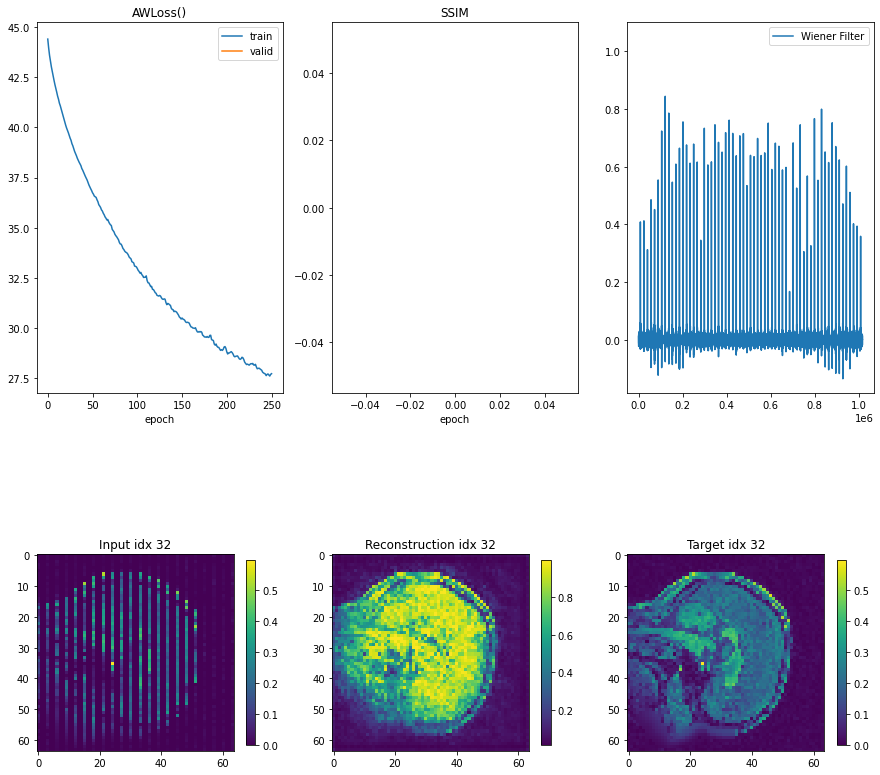

 83% (251 of 300) |##################    | Elapsed Time: 0:03:41 ETA:   0:01:08
 84% (252 of 300) |##################    | Elapsed Time: 0:03:42 ETA:   0:01:06
 84% (253 of 300) |##################    | Elapsed Time: 0:03:42 ETA:   0:00:56
 84% (254 of 300) |##################    | Elapsed Time: 0:03:43 ETA:   0:00:39
 85% (255 of 300) |##################    | Elapsed Time: 0:03:44 ETA:   0:00:38
 85% (256 of 300) |##################    | Elapsed Time: 0:03:45 ETA:   0:00:37
 85% (257 of 300) |##################    | Elapsed Time: 0:03:46 ETA:   0:00:36
 86% (258 of 300) |##################    | Elapsed Time: 0:03:47 ETA:   0:00:35
 86% (259 of 300) |##################    | Elapsed Time: 0:03:48 ETA:   0:00:35
 86% (260 of 300) |###################   | Elapsed Time: 0:03:48 ETA:   0:00:34
 87% (261 of 300) |###################   | Elapsed Time: 0:03:49 ETA:   0:00:33
 87% (262 of 300) |###################   | Elapsed Time: 0:03:50 ETA:   0:00:32
 87% (263 of 300) |###################  


 {'epoch': 299, 'loss': 26.76242446899414, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
 argidx T, v:  8064 120967


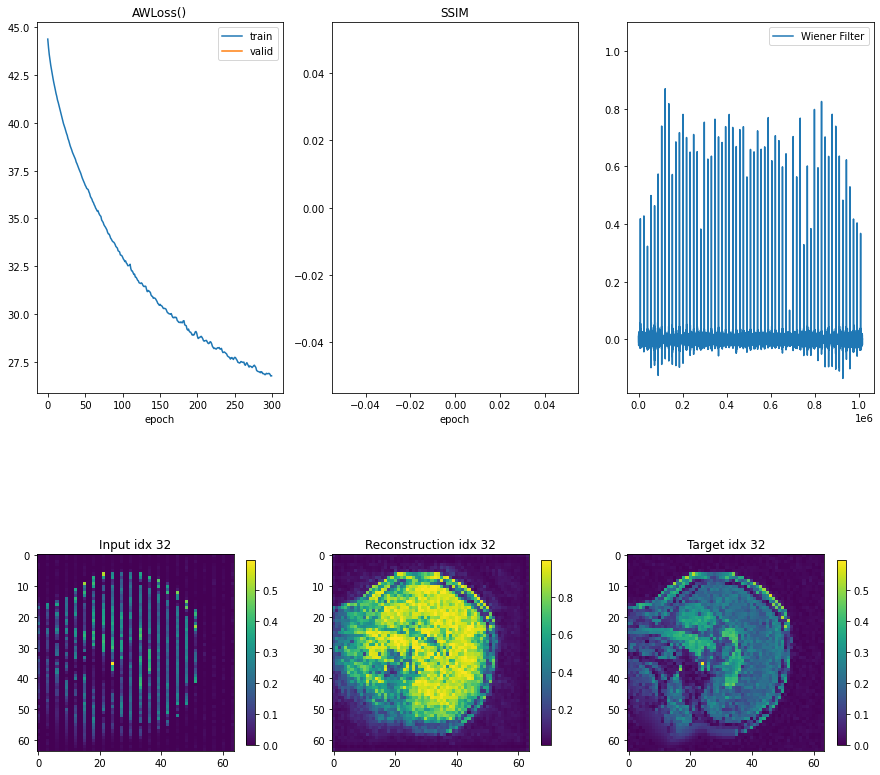

100% (300 of 300) |######################| Elapsed Time: 0:04:23 Time:  0:04:23




Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 36489.74609375, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


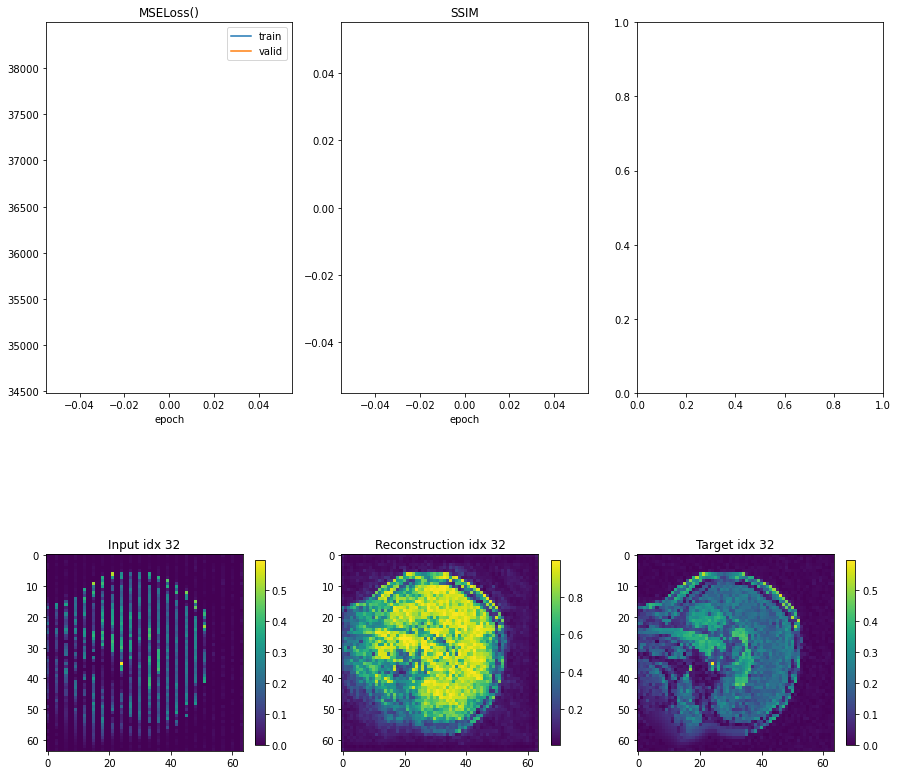

  1% (1 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:02:28
  2% (2 of 100) |                        | Elapsed Time: 0:00:02 ETA:   0:01:54
  3% (3 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:42
  4% (4 of 100) |                        | Elapsed Time: 0:00:03 ETA:   0:01:19
  5% (5 of 100) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:19
  6% (6 of 100) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:18
  7% (7 of 100) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:18
  8% (8 of 100) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:16
  9% (9 of 100) |##                      | Elapsed Time: 0:00:08 ETA:   0:01:15
 10% (10 of 100) |##                     | Elapsed Time: 0:00:08 ETA:   0:01:14
 11% (11 of 100) |##                     | Elapsed Time: 0:00:09 ETA:   0:01:13
 12% (12 of 100) |##                     | Elapsed Time: 0:00:10 ETA:   0:01:12
 13% (13 of 100) |##                    


 {'epoch': 50, 'loss': 13779.4716796875, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


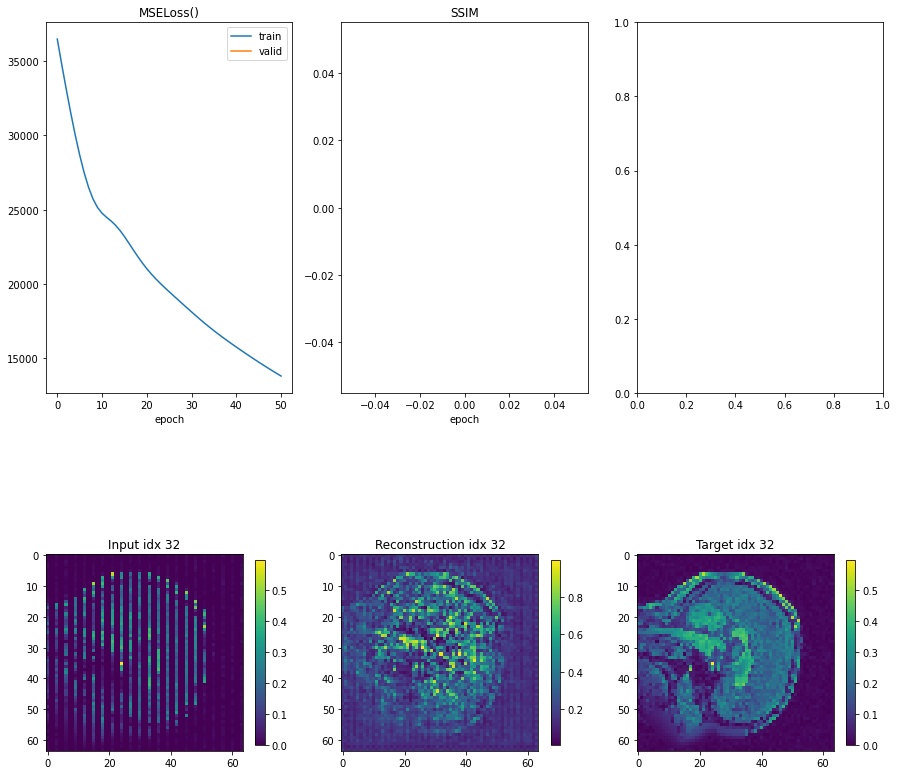

 51% (51 of 100) |###########            | Elapsed Time: 0:00:43 ETA:   0:00:57
 52% (52 of 100) |###########            | Elapsed Time: 0:00:44 ETA:   0:00:56
 53% (53 of 100) |############           | Elapsed Time: 0:00:45 ETA:   0:00:49
 54% (54 of 100) |############           | Elapsed Time: 0:00:46 ETA:   0:00:38
 55% (55 of 100) |############           | Elapsed Time: 0:00:47 ETA:   0:00:37
 56% (56 of 100) |############           | Elapsed Time: 0:00:47 ETA:   0:00:37
 57% (57 of 100) |#############          | Elapsed Time: 0:00:48 ETA:   0:00:36
 58% (58 of 100) |#############          | Elapsed Time: 0:00:49 ETA:   0:00:35
 59% (59 of 100) |#############          | Elapsed Time: 0:00:50 ETA:   0:00:34
 60% (60 of 100) |#############          | Elapsed Time: 0:00:51 ETA:   0:00:33
 61% (61 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:32
 62% (62 of 100) |##############         | Elapsed Time: 0:00:52 ETA:   0:00:31
 63% (63 of 100) |##############        


 {'epoch': 99, 'loss': 7322.6943359375, 'ssim (validation)': -1.0}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


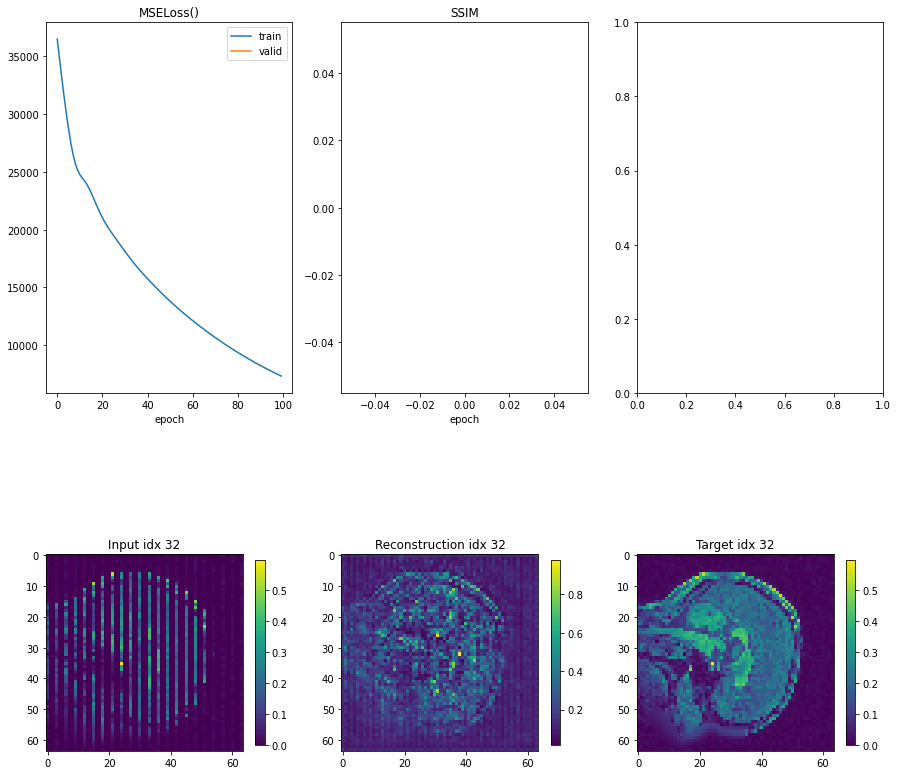

100% (100 of 100) |######################| Elapsed Time: 0:01:24 Time:  0:01:24


In [26]:
model = make_model(channels=x_sample.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, valid_loader=None, nepochs=300, log_frequency=50, sample_input=x_sample, sample_target=y_sample, device=device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate/10.)
train_model(model, optimizer, l2loss, train_loader, valid_loader=None, nepochs=100, log_frequency=50, sample_input=x_sample, sample_target=y_sample, device=device)




Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 251 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 592508.6875, 'ssim (validation)': -1.0}
torch.Size([256, 64, 64]) torch.Size([256, 64, 64])


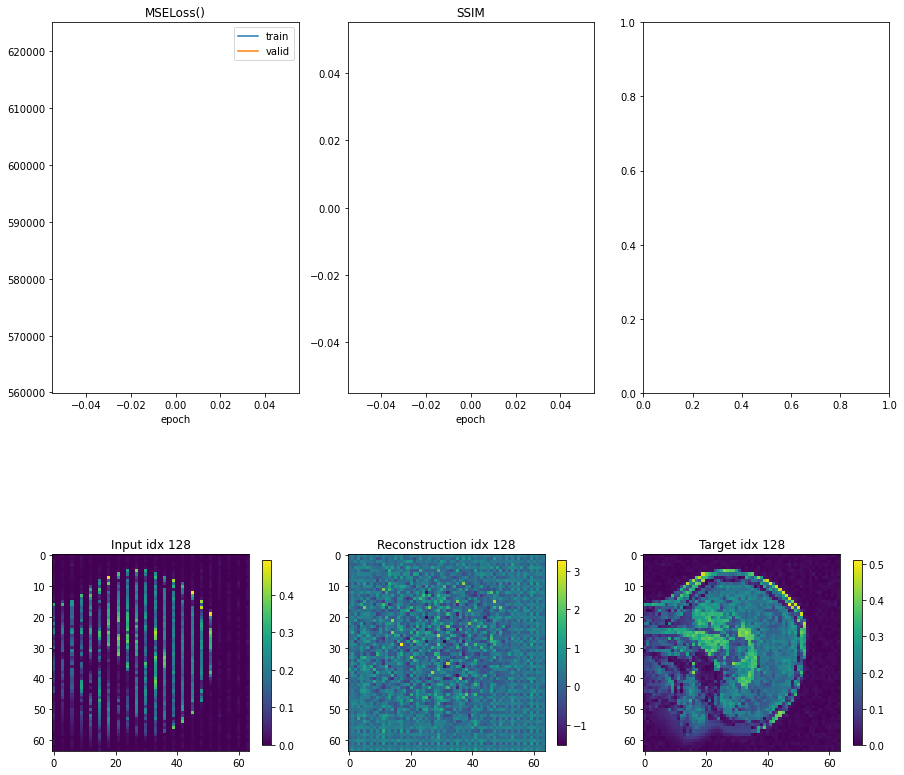

 20% (1 of 5) |#####                     | Elapsed Time: 0:00:01 ETA:   0:00:06
 40% (2 of 5) |##########                | Elapsed Time: 0:00:02 ETA:   0:00:03
 60% (3 of 5) |###############           | Elapsed Time: 0:00:03 ETA:   0:00:02
 80% (4 of 5) |####################      | Elapsed Time: 0:00:04 ETA:   0:00:00



 {'epoch': 4, 'loss': 73229.1171875, 'ssim (validation)': -1.0}
torch.Size([256, 64, 64]) torch.Size([256, 64, 64])


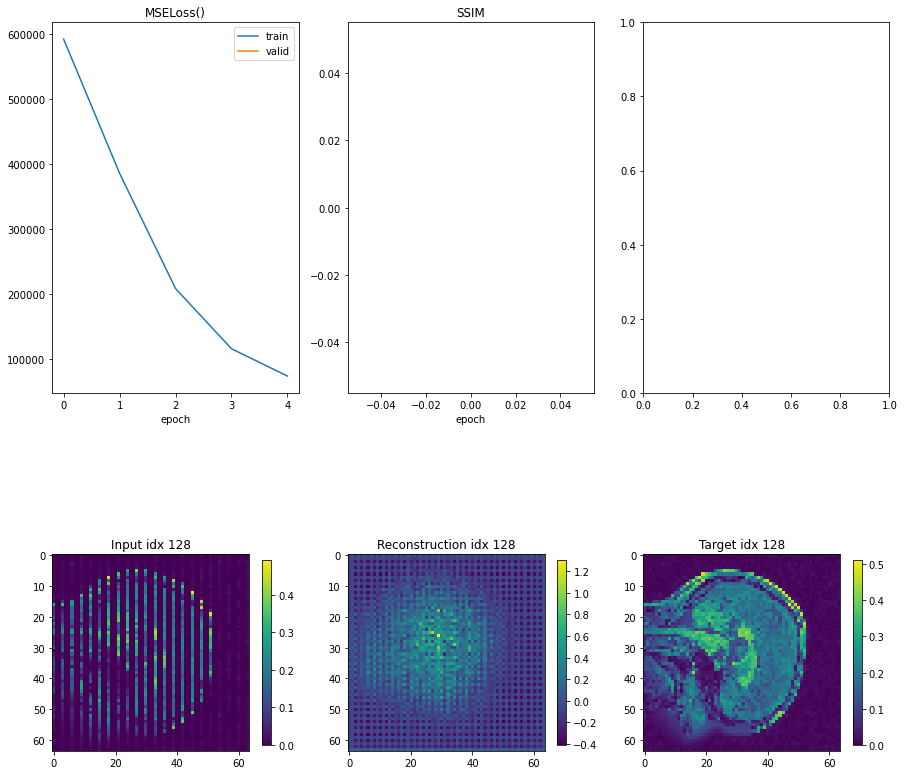

100% (5 of 5) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05




Training started ...


N/A% (0 of 95) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 180.00286865234375, 'ssim (validation)': -1.0}
torch.Size([256, 64, 64]) torch.Size([256, 64, 64])
 argidx T, v:  8064 3734500


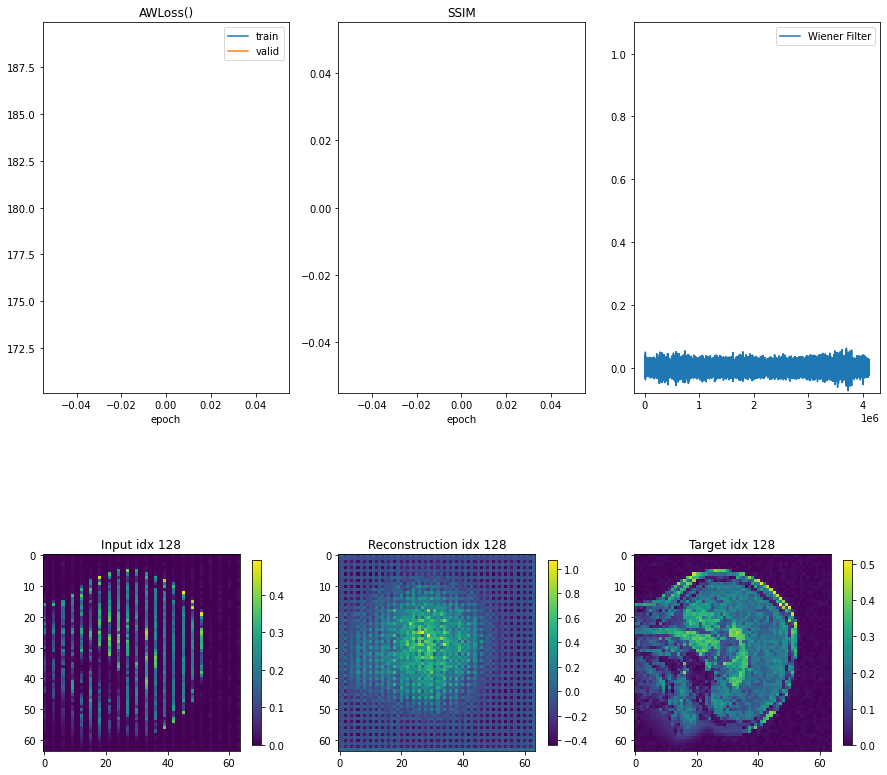

  1% (1 of 95) |                         | Elapsed Time: 0:00:03 ETA:   0:04:44
  2% (2 of 95) |                         | Elapsed Time: 0:00:04 ETA:   0:03:07
  3% (3 of 95) |                         | Elapsed Time: 0:00:04 ETA:   0:02:33
  4% (4 of 95) |#                        | Elapsed Time: 0:00:05 ETA:   0:01:28
  5% (5 of 95) |#                        | Elapsed Time: 0:00:06 ETA:   0:01:27
  6% (6 of 95) |#                        | Elapsed Time: 0:00:07 ETA:   0:01:25
  7% (7 of 95) |#                        | Elapsed Time: 0:00:08 ETA:   0:01:25
  8% (8 of 95) |##                       | Elapsed Time: 0:00:09 ETA:   0:01:27
  9% (9 of 95) |##                       | Elapsed Time: 0:00:10 ETA:   0:01:25
 10% (10 of 95) |##                      | Elapsed Time: 0:00:11 ETA:   0:01:24
 11% (11 of 95) |##                      | Elapsed Time: 0:00:12 ETA:   0:01:22
 12% (12 of 95) |###                     | Elapsed Time: 0:00:13 ETA:   0:01:21
 13% (13 of 95) |###                    


 {'epoch': 25, 'loss': 180.1751708984375, 'ssim (validation)': -1.0}
torch.Size([256, 64, 64]) torch.Size([256, 64, 64])
 argidx T, v:  8064 3621088


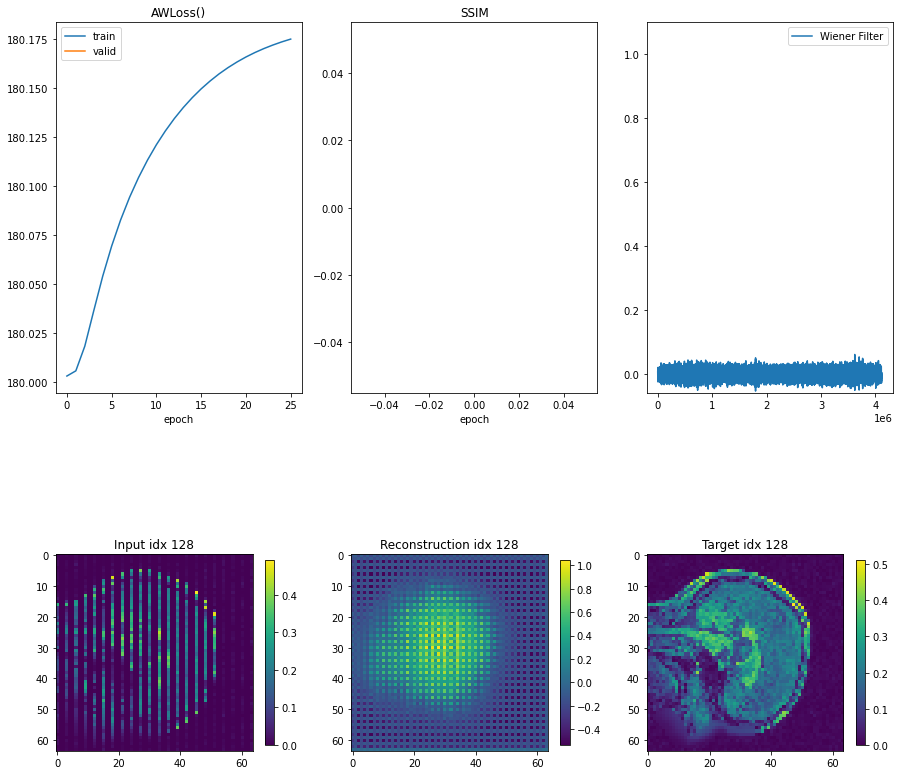

 27% (26 of 95) |######                  | Elapsed Time: 0:00:29 ETA:   0:03:41
 28% (27 of 95) |######                  | Elapsed Time: 0:00:30 ETA:   0:02:21
 29% (28 of 95) |#######                 | Elapsed Time: 0:00:31 ETA:   0:01:54
 30% (29 of 95) |#######                 | Elapsed Time: 0:00:32 ETA:   0:01:03
 31% (30 of 95) |#######                 | Elapsed Time: 0:00:33 ETA:   0:01:02
 32% (31 of 95) |#######                 | Elapsed Time: 0:00:34 ETA:   0:01:01
 33% (32 of 95) |########                | Elapsed Time: 0:00:35 ETA:   0:01:00
 34% (33 of 95) |########                | Elapsed Time: 0:00:36 ETA:   0:00:59


KeyboardInterrupt: 

In [ ]:
# model = make_model()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train_model(model, optimizer, l2loss, train_loader, valid_loader=None, nepochs=5, log_frequency=25, sample_input=x_sample, sample_target=y_sample, device=device)
# train_model(model, optimizer, awloss, train_loader, valid_loader=None, nepochs=95, log_frequency=25, sample_input=x_sample, sample_target=y_sample, device=device)

Normalisation / Activation

Joint AWLoss and MSE

Frequency continuation

Resize channels / Volumetric data with one channel?
3D FFT -- multigauss generation fails at large dimensions :'(

Larger batch / Validation and test set

SSMI (??)
